In [1]:
from keras_unet_collection import models, losses
import tensorflow as tf
from tensorflow import keras
import xarray as xr
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in data
input_ds = xr.open_dataset("conv_test/HRRR_all_input_2016_0413_0022.nc")
output_ds = xr.open_dataset("conv_test/MESH_HRRR_20160413_03z.nc")

In [4]:
input_ds

<xarray.Dataset>
Dimensions:       (time: 19, x: 1799, y: 1059)
Coordinates:
    longitude     (y, x) float64 ...
    latitude      (y, x) float64 ...
  * time          (time) datetime64[ns] 2016-04-13T03:00:00 ... 2016-04-13T22...
Dimensions without coordinates: x, y
Data variables:
    ref           (time, y, x) float32 ...
    cape          (time, y, x) float32 ...
    ltng          (time, y, x) float32 ...
    accum_precip  (time, y, x) float32 ...

In [3]:
input_array = np.stack([input_ds.ref.values,input_ds.cape.values,input_ds.accum_precip.values,input_ds.ltng.values])
input_array.shape

(4, 19, 1059, 1799)

AttributeError: 'Dataset' object has no attribute 'shape'

In [4]:
#Setting Training, Validation, Testing data

X_training = input_array[:,:4,200:712,600:1112]
X_validation = input_array[:,4:6,200:712,600:1112]
X_testing = input_array[:,6:,200:712,600:1112]

Y_training = output_ds.unknown[4:,200:712,600:1112].values
Y_validation = output_ds.unknown[4:,200:712,600:1112].values
Y_testing = output_ds.unknown[6:,200:712,600:1112].values

X_total = input_array[:,0:6,200:712,600:1112]
Y_total = output_ds.unknown[:,200:712,600:1112].values

In [5]:
X_total.shape

(4, 6, 512, 512)

In [7]:
X_training.shape

(4, 512, 512, 4)

In [6]:
Y_testing.shape

(0, 512, 512)

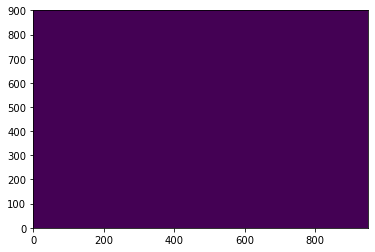

In [12]:
#True output:
plt.pcolormesh(Y_total[5,:,:])

In [5]:
X_training = np.swapaxes(X_training,0,1)
X_training = np.swapaxes(X_training,1,3)
X_validation = np.swapaxes(X_validation,0,1)
X_validation = np.swapaxes(X_validation,1,3)
X_testing = np.swapaxes(X_testing,0,1)
X_testing = np.swapaxes(X_testing,1,3)
X_total = np.swapaxes(X_total,0,1)
X_total = np.swapaxes(X_total,1,3)
X_testing.shape

(13, 512, 512, 4)

In [6]:
Y_training = np.swapaxes(Y_training,1,2)
Y_validation = np.swapaxes(Y_validation,1,2)
Y_testing = np.swapaxes(Y_testing,1,2)
Y_total = np.swapaxes(Y_total,1,2)
Y_testing.shape

(0, 512, 512)

In [9]:
Y_total.max()

-1.0

## Making Unet

In [7]:
#making a basic unet
# image_size -- length by width by channels used to predict the outcome (like CAPE, refc, ...), time will be batch-size which comes in in the generator
# filter_num --  ex: [32,64,128,256,512,1024], but I think these will be proportional to original image size
# num_labels -- number of targets we are trying to predict = 1
# stack_num_down -- number of layers we go down (he did 5)
# stack_num_up -- number of layers we go up (he did 5)
# activation -- activation function in the hidden layers
# output_activation -- activation function for the output layer
# batch_norm -- scales arrays to a common scale, we usually want this on to keep units from having too much of an effect
# pool -- how do you want to pool the data during downscaling? True = max
# unpool -- how do you want to interpolate during upscaling? True = ??
# name -- name for the layers when summary function is called

model = models.unet_2d((512,512,4),
                       filter_num = [64,128], #[112,224,448,896,1792],
                       n_labels = 1,
                       stack_num_down = 1,
                       stack_num_up = 1,
                       activation = 'LeakyReLU',
                       output_activation = 'ReLU',
                       batch_norm = True,
                       pool = True,
                       unpool = True,
                       name = 'unet')


In [8]:
#compiling a unet
#unets use gradient descent
#Adam is an optimizer for the model which is a gradient descent replacemtne
# learning_rate - how fast does the model learn? Too high, the model will finish training before it's actually learned, too slow is inefficient
# start learning with 10^-4, 10^-3, 10^-5
# loss function measure the error between the predicted value and the truth value. Error should go down durring training
# metrics could be AUC or accuracy - Andrew doesn't worry about this one. Doesn't affect the model, just affects the model output
`
learning_rate = 1e-4
loss_function = keras.losses.MeanSquaredError()     #loss_function = 'tversky' # could be 'dice', 'tversky', 'categorical_crossentropy', probably more too

adam = Adam(learning_rate=learning_rate)
model.compile(loss=loss_function, optimizer=adam, metrics=tf.keras.metrics.Accuracy()) #Accurracy

In [11]:
#print out the model
model.summary()

#the first output dimension will say "None" because it's the batch size and it's not declared

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 64) 2304        input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 64) 256         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (LeakyR (None, 512, 512, 64) 0           unet_down0_0_bn[0][0]            
_________________________________________________________________________________________

In [10]:
#validation frequency = how many epochs should it go in between training and tweaking the model
#epochs = number of times it runs over your dataset
#batch_size = number of items in the training dataset ||| steps_per_epoch if using a generator
#validation_steps = same thing as steps per epoch but during validation
#callbacks = extra setting for the model - like model checkpoint, early stopping
    #tf.keras.callbacks.ModelCheckpoint - probably want to use this - saves the model periodically - usually moniter the loss function, save_best_only = True
    #early stopping = EarlyStopping('loss',patience=500,verbose=2) - will stop the model when it starts to perform badly on the validation data
#workers = how many threads=CPU to use to train batches in parallel (=2)? based on hardware
#use_multiprocessing=True
#max_queue_size=100000 - the queue holds the batches if the GPU gets backed up
    
#trained_model = model.fit(train_dataset.repeat(),
#                    validation_data=validation_dataset.repeat())

#'''
#X_training = np.swapaxes(X_training,0,2)
#Y_training = np.swapaxes(Y_training,0,2)

early_stopping = EarlyStopping('loss',patience=500,verbose=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_test_data/model_test', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')

trained_model = model.fit(X_total,
                          Y_total,
                          validation_freq=5,
                          epochs=20,
                          batch_size=23, #steps_per_epoch=23,
                          validation_steps=5,
                          callbacks=[early_stopping, checkpoint],
                          verbose=2,
                          workers=2,
                          use_multiprocessing=True,
                          max_queue_size=100)    #'''
#model.fit?

Epoch 1/20
1/1 - 139s - loss: 2.0966 - accuracy: 0.0000e+00

Epoch 00001: loss improved from inf to 2.09659, saving model to unet_test_data\model_test
INFO:tensorflow:Assets written to: unet_test_data\model_test\assets
Epoch 2/20
1/1 - 119s - loss: 1.3369 - accuracy: 0.0000e+00

Epoch 00002: loss improved from 2.09659 to 1.33693, saving model to unet_test_data\model_test
INFO:tensorflow:Assets written to: unet_test_data\model_test\assets
Epoch 3/20
1/1 - 129s - loss: 1.1022 - accuracy: 0.0000e+00

Epoch 00003: loss improved from 1.33693 to 1.10221, saving model to unet_test_data\model_test
INFO:tensorflow:Assets written to: unet_test_data\model_test\assets
Epoch 4/20
1/1 - 116s - loss: 1.1569 - accuracy: 0.0000e+00

Epoch 00004: loss did not improve from 1.10221
Epoch 5/20
1/1 - 119s - loss: 1.1221 - accuracy: 0.0000e+00

Epoch 00005: loss did not improve from 1.10221
Epoch 6/20
1/1 - 126s - loss: 1.0457 - accuracy: 0.0000e+00

Epoch 00006: loss improved from 1.10221 to 1.04573, saving

In [15]:
trained_model

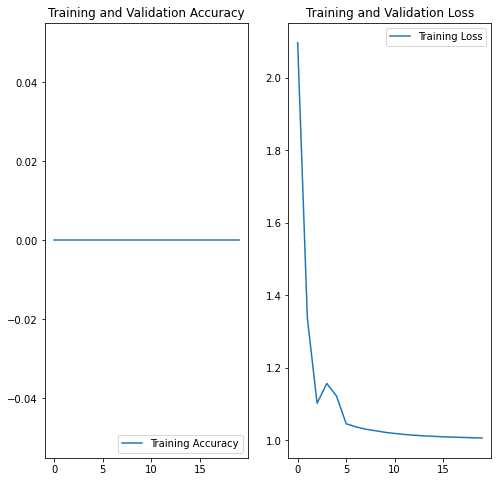

In [11]:
acc = trained_model.history['accuracy']
#val_acc = trained_model.history['val_accuracy']

loss = trained_model.history['loss']
#val_loss = trained_model.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()